libraries

In [61]:
using UniversalDiffEq, DataFrames, CSV, Plots, Serialization

function to plot phase planes

In [62]:
# visualize 2 variables (e.g., Coral vs Macro) by fixing the third variable (e.g., Turf) to be 1 - Coral - Macro
function phase_plane(model; start = 0.05, stop = 1.0, step = 0.1, max_T = 250, 
                     title = "Plot Title", xlabel = "Macroalgae Cover", ylabel = "Coral Cover")
    
    u0_array = Vector{Vector{Float64}}()
    for macro_ in start:step:stop
        for coral in start:step:stop
            if (coral + macro_ > 1)
                continue 
            end
            turf = 1.0 - coral - macro_
            #push!(u0_array, [coral, macro_, turf]) 
            push!(u0_array, [coral, macro_])
        end 
    end 

    plt = UniversalDiffEq.phase_plane(model, u0_array, T = max_T, idx = [2, 1])
    title!(plt, title)
    xlabel!(plt, xlabel)
    ylabel!(plt, ylabel)
    return plt 
end

phase_plane (generic function with 1 method)

Coral dominant with no noise on g

In [63]:
# Read in data
df = CSV.read("data/Mumby_coral_dominant_model_output_nonoise.csv", DataFrame)

# Extract the columns you want as the state variables 
times = df.Time
observations = Array(df[:, ["Coral", "Macro"]])'

# Prepare data for model: DataFrame with all relevant columns
df_model = df[:, ["Time", "Coral", "Macro"]]


51×3 DataFrame
 Row │ Time   Coral     Macro      
     │ Int64  Float64   Float64    
─────┼─────────────────────────────
   1 │     0  0.3       0.3
   2 │     2  0.277788  0.272635
   3 │     4  0.27324   0.26223
   4 │     6  0.274116  0.256244
   5 │     8  0.277103  0.251224
   6 │    10  0.281224  0.246036
   7 │    12  0.28623   0.240243
   8 │    14  0.292124  0.233619
  ⋮  │   ⋮       ⋮          ⋮
  45 │    88  0.56      1.45616e-7
  46 │    90  0.56      8.25416e-8
  47 │    92  0.56      4.75131e-8
  48 │    94  0.56      2.71155e-8
  49 │    96  0.56      1.58248e-8
  50 │    98  0.56      9.42225e-9
  51 │   100  0.56      5.48853e-9
                    36 rows omitted

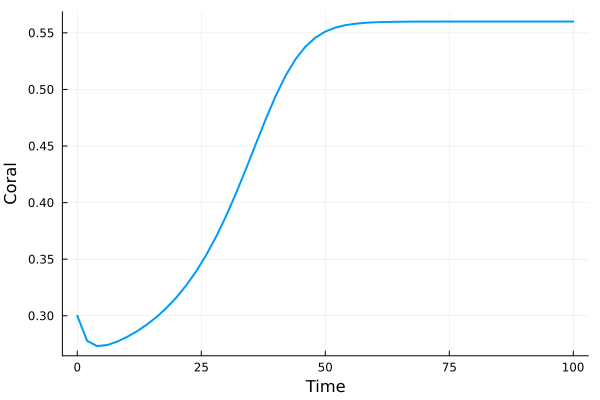

In [64]:
plot(df.Time, df.Coral, xlabel = "Time", ylabel="Coral", label="", lw=2)

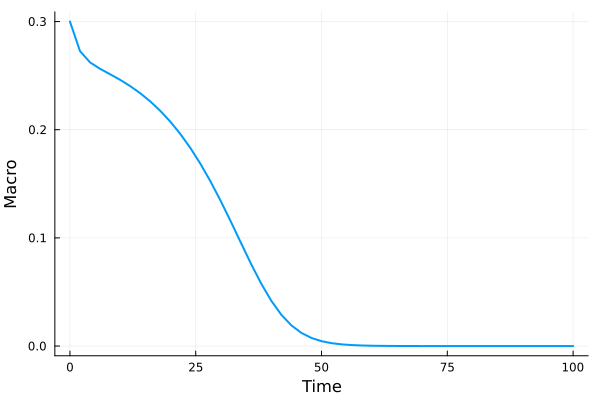

In [65]:
plot(df.Time, df.Macro, xlabel = "Time", ylabel="Macro", label="", lw=2)

In [66]:
# Estiamte some rates as constants
NN, params = UniversalDiffEq.SimpleNeuralNetwork(2, 1)
init_parameters = (NN = params, r1 = 0.8, r2 = 0.3, r3 = 0.1, r4 =0.5)
function dudt(u, p, t)
    #r = NN(u, p.NN)
    r = exp.(NN(u,p.NN)) # bounding rates to positive values
	Coral,MacroAlg = u
    Turf = 1 - Coral - MacroAlg
    dC = p.r1*Coral*Turf - p.r2*Coral - p.r3*Coral*MacroAlg
    #dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - ((r[1]*MacroAlg)/(MacroAlg+Turf))
    dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - r[1]*MacroAlg
    return [dC,dM]
end

dudt (generic function with 1 method)

In [67]:
model = CustomDerivatives(df_model, dudt, init_parameters)


┌ Warning: Found unexpected value for time_column_name:Time, It is reccomended to set kwarg: time_column_name to match your data
└ @ UniversalDiffEq /Users/cheyennejarman/.julia/packages/UniversalDiffEq/bV4w7/src/helpers.jl:626


UDE([0, 2, 4, 6, 8, 10, 12, 14, 16, 18  …  82, 84, 86, 88, 90, 92, 94, 96, 98, 100], [0.3 0.27778802299878874 … 0.5599999797172653 0.5599999881842599; 0.3 0.2726350615722912 … 9.422250139969222e-9 5.488527719145118e-9], 0, 51×3 DataFrame
 Row │ Time   Coral     Macro      
     │ Int64  Float64   Float64    
─────┼─────────────────────────────
   1 │     0  0.3       0.3
   2 │     2  0.277788  0.272635
   3 │     4  0.27324   0.26223
   4 │     6  0.274116  0.256244
   5 │     8  0.277103  0.251224
   6 │    10  0.281224  0.246036
   7 │    12  0.28623   0.240243
   8 │    14  0.292124  0.233619
  ⋮  │   ⋮       ⋮          ⋮
  45 │    88  0.56      1.45616e-7
  46 │    90  0.56      8.25416e-8
  47 │    92  0.56      4.75131e-8
  48 │    94  0.56      2.71155e-8
  49 │    96  0.56      1.58248e-8
  50 │    98  0.56      9.42225e-9
  51 │   100  0.56      5.48853e-9
                    36 rows omitted, 0, (uhat = [0.001 0.001 … 0.001 0.001; 0.001 0.001 … 0.001 0.001], process_model = (

In [68]:
train!(model; 
    loss_function = "derivative matching",
    loss_options = (d=2),  
    optimizer = "ADAM",
    regularization_weight = 1e-4,#0.0,
    verbose = true,
    optim_options = (maxiter = 100, step_size = 0.01)
)

0.343 0.251 0.181 0.129 0.093 0.068 0.051 0.037 0.027 0.018 0.012 0.007 0.003 0.002 0.001 0.002 0.004 0.005 0.006 0.007 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.009 0.009 0.008 0.008 0.007 0.006 0.006 0.005 0.004 0.004 0.003 0.003 0.003 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.0 0.0 0.0 0.0 0.0 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

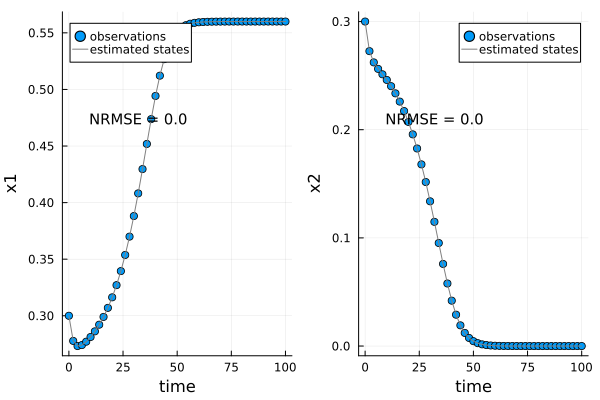

In [69]:
plot_state_estimates(model)

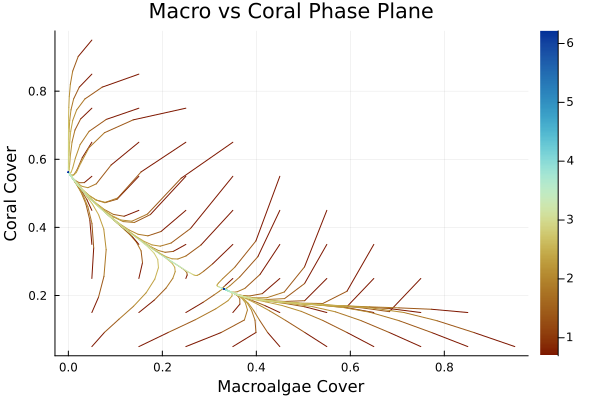

In [70]:
phasePlot = phase_plane(model;
    title = "Macro vs Coral Phase Plane",
    xlabel = "Macroalgae Cover",
    ylabel = "Coral Cover"
)
display(phasePlot)

Coral dominant IC = 0.8 with no noise on g

In [71]:
# Read in data
df = CSV.read("data/Mumby_coral_dominant_ic08_model_output_nonoise.csv", DataFrame)

# Extract the columns you want as the state variables 
times = df.Time
observations = Array(df[:, ["Coral", "Macro"]])'

# Prepare data for model: DataFrame with all relevant columns
df_model = df[:, ["Time", "Coral", "Macro"]]


51×3 DataFrame
 Row │ Time   Coral     Macro        
     │ Int64  Float64   Float64      
─────┼───────────────────────────────
   1 │     0  0.8        0.1
   2 │     2  0.587351   0.0293906
   3 │     4  0.553498   0.0159782
   4 │     6  0.549151   0.00945681
   5 │     8  0.551212   0.00564964
   6 │    10  0.554001   0.0033524
   7 │    12  0.556194   0.00197286
   8 │    14  0.557677   0.0011536
  ⋮  │   ⋮       ⋮           ⋮
  45 │    88  0.56      -1.51873e-10
  46 │    90  0.56      -1.05299e-10
  47 │    92  0.56      -7.08634e-11
  48 │    94  0.56      -5.33857e-11
  49 │    96  0.56      -3.18745e-11
  50 │    98  0.56      -1.79239e-11
  51 │   100  0.56      -1.02584e-11
                      36 rows omitted

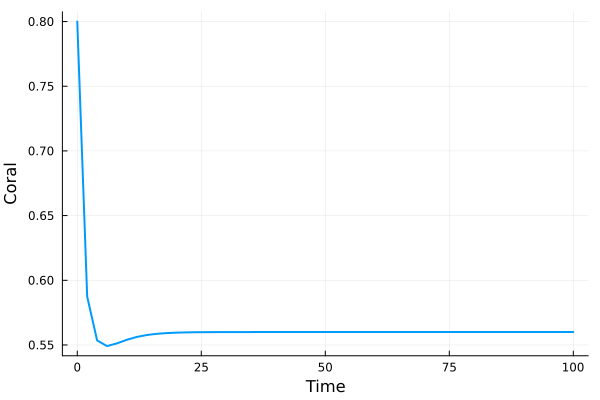

In [72]:
plot(df.Time, df.Coral, xlabel = "Time", ylabel="Coral", label="", lw=2)

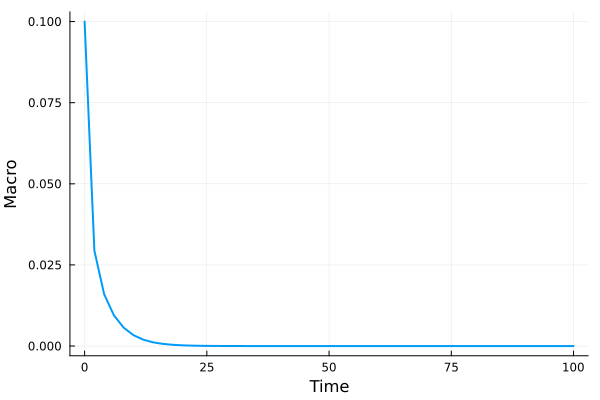

In [73]:
plot(df.Time, df.Macro, xlabel = "Time", ylabel="Macro", label="", lw=2)

In [74]:
# Estiamte some rates as constants
NN, params = UniversalDiffEq.SimpleNeuralNetwork(2, 1)
init_parameters = (NN = params, r1 = 0.8, r2 = 0.3, r3 = 0.1, r4 =0.5)
function dudt(u, p, t)
    #r = NN(u, p.NN)
    r = exp.(NN(u,p.NN)) # bounding rates to positive values
	Coral,MacroAlg = u
    Turf = 1 - Coral - MacroAlg
    dC = p.r1*Coral*Turf - p.r2*Coral - p.r3*Coral*MacroAlg
    #dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - ((r[1]*MacroAlg)/(MacroAlg+Turf))
    dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - r[1]*MacroAlg
    return [dC,dM]
end

dudt (generic function with 1 method)

In [75]:
model = CustomDerivatives(df_model, dudt, init_parameters)


┌ Warning: Found unexpected value for time_column_name:Time, It is reccomended to set kwarg: time_column_name to match your data
└ @ UniversalDiffEq /Users/cheyennejarman/.julia/packages/UniversalDiffEq/bV4w7/src/helpers.jl:626


UDE([0, 2, 4, 6, 8, 10, 12, 14, 16, 18  …  82, 84, 86, 88, 90, 92, 94, 96, 98, 100], [0.8 0.5873512313676584 … 0.5600000000372551 0.5600000000208049; 0.1 0.029390620856245987 … -1.7923884270509122e-11 -1.02584096646155e-11], 0, 51×3 DataFrame
 Row │ Time   Coral     Macro        
     │ Int64  Float64   Float64      
─────┼───────────────────────────────
   1 │     0  0.8        0.1
   2 │     2  0.587351   0.0293906
   3 │     4  0.553498   0.0159782
   4 │     6  0.549151   0.00945681
   5 │     8  0.551212   0.00564964
   6 │    10  0.554001   0.0033524
   7 │    12  0.556194   0.00197286
   8 │    14  0.557677   0.0011536
  ⋮  │   ⋮       ⋮           ⋮
  45 │    88  0.56      -1.51873e-10
  46 │    90  0.56      -1.05299e-10
  47 │    92  0.56      -7.08634e-11
  48 │    94  0.56      -5.33857e-11
  49 │    96  0.56      -3.18745e-11
  50 │    98  0.56      -1.79239e-11
  51 │   100  0.56      -1.02584e-11
                      36 rows omitted, 0, (uhat = [0.001 0.001 … 0.001 0.001

In [76]:
train!(model; 
    loss_function = "derivative matching",
    loss_options = (d=2),  
    optimizer = "ADAM",
    regularization_weight = 1e-4,#0.0,
    verbose = true,
    optim_options = (maxiter = 100, step_size = 0.01)
)

0.053 0.032 0.018 0.011 0.01 0.012 0.015 0.017 0.017 0.016 0.014 0.011 0.009 0.008 0.008 0.008 0.009 0.01 0.01 0.01 0.009 0.008 0.007 0.007 0.006 0.006 0.006 0.007 0.007 0.007 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 

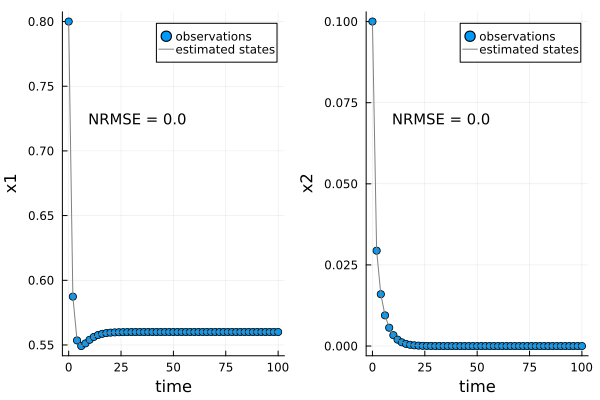

In [77]:
plot_state_estimates(model)

In [ ]:
phasePlot = phase_plane(model;
    title = "Macro vs Coral Phase Plane",
    xlabel = "Macroalgae Cover",
    ylabel = "Coral Cover"
)
display(phasePlot)

Macro dominant with no noise on g

In [ ]:
# Read in data
df = CSV.read("data/Mumby_macro_dominant_model_output_nonoise.csv", DataFrame)

# Extract the columns you want as the state variables 
times = df.Time
observations = Array(df[:, ["Coral", "Macro"]])'

# Prepare data for model: DataFrame with all relevant columns
df_model = df[:, ["Time", "Coral", "Macro"]]


In [ ]:
plot(df.Time, df.Coral, xlabel = "Time", ylabel="Coral", label="", lw=2)

In [ ]:
plot(df.Time, df.Macro, xlabel = "Time", ylabel="Macro", label="", lw=2)

In [ ]:
# Estiamte some rates as constants
NN, params = UniversalDiffEq.SimpleNeuralNetwork(2, 1)
init_parameters = (NN = params, r1 = 0.8, r2 = 0.3, r3 = 0.1, r4 =0.5)
function dudt(u, p, t)
    #r = NN(u, p.NN)
    r = exp.(NN(u,p.NN)) # bounding rates to positive values
	Coral,MacroAlg = u
    Turf = 1 - Coral - MacroAlg
    dC = p.r1*Coral*Turf - p.r2*Coral - p.r3*Coral*MacroAlg
    #dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - ((r[1]*MacroAlg)/(MacroAlg+Turf))
    dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - r[1]*MacroAlg
    return [dC,dM]
end

In [ ]:
model = CustomDerivatives(df_model, dudt, init_parameters)


In [ ]:
train!(model; 
    loss_function = "derivative matching",
    loss_options = (d=2),  
    optimizer = "ADAM",
    regularization_weight = 1e-4,#0.0,
    verbose = true,
    optim_options = (maxiter = 100, step_size = 0.01)
)

In [ ]:
plot_state_estimates(model)

In [ ]:
phasePlot = phase_plane(model;
    title = "Macro vs Coral Phase Plane",
    xlabel = "Macroalgae Cover",
    ylabel = "Coral Cover"
)
display(phasePlot)

Coral dominant with noise on g

In [ ]:
# Read in data
df = CSV.read("data/Mumby_coral_dominant_model_output_noiseong.csv", DataFrame)

# Extract the columns you want as the state variables 
times = df.Time
observations = Array(df[:, ["Coral", "Macro"]])'

# Prepare data for model: DataFrame with all relevant columns
df_model = df[:, ["Time", "Coral", "Macro"]]


In [ ]:
plot(df.Time, df.Coral, xlabel = "Time", ylabel="Coral", label="", lw=2)

In [ ]:
plot(df.Time, df.Macro, xlabel = "Time", ylabel="Macro", label="", lw=2)

In [ ]:
# Estiamte some rates as constants
NN, params = UniversalDiffEq.SimpleNeuralNetwork(2, 1)
init_parameters = (NN = params, r1 = 0.8, r2 = 0.3, r3 = 0.1, r4 =0.5)
function dudt(u, p, t)
    #r = NN(u, p.NN)
    r = exp.(NN(u,p.NN)) # bounding rates to positive values
	Coral,MacroAlg = u
    Turf = 1 - Coral - MacroAlg
    dC = p.r1*Coral*Turf - p.r2*Coral - p.r3*Coral*MacroAlg
    #dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - ((r[1]*MacroAlg)/(MacroAlg+Turf))
    dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - r[1]*MacroAlg
    return [dC,dM]
end

In [ ]:
model = CustomDerivatives(df_model, dudt, init_parameters)


In [ ]:
train!(model; 
    loss_function = "derivative matching",
    loss_options = (d=2),  
    optimizer = "ADAM",
    regularization_weight = 1e-4,#0.0,
    verbose = true,
    optim_options = (maxiter = 100, step_size = 0.01)
)

In [ ]:
plot_state_estimates(model)

In [ ]:
phasePlot = phase_plane(model;
    title = "Macro vs Coral Phase Plane",
    xlabel = "Macroalgae Cover",
    ylabel = "Coral Cover"
)
display(phasePlot)

Coral dominant with noise on g and IC= 0.8

In [ ]:
# Read in data
df = CSV.read("data/Mumby_coral_dominant_ic08_model_output_noiseong.csv", DataFrame)

# Extract the columns you want as the state variables 
times = df.Time
observations = Array(df[:, ["Coral", "Macro"]])'

# Prepare data for model: DataFrame with all relevant columns
df_model = df[:, ["Time", "Coral", "Macro"]]


In [ ]:
plot(df.Time, df.Coral, xlabel = "Time", ylabel="Coral", label="", lw=2)

In [ ]:
plot(df.Time, df.Macro, xlabel = "Time", ylabel="Macro", label="", lw=2)

In [ ]:
# Estiamte some rates as constants
NN, params = UniversalDiffEq.SimpleNeuralNetwork(2, 1)
init_parameters = (NN = params, r1 = 0.8, r2 = 0.3, r3 = 0.1, r4 =0.5)
function dudt(u, p, t)
    #r = NN(u, p.NN)
    r = exp.(NN(u,p.NN)) # bounding rates to positive values
	Coral,MacroAlg = u
    Turf = 1 - Coral - MacroAlg
    dC = p.r1*Coral*Turf - p.r2*Coral - p.r3*Coral*MacroAlg
    #dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - ((r[1]*MacroAlg)/(MacroAlg+Turf))
    dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - r[1]*MacroAlg
    return [dC,dM]
end

In [ ]:
model = CustomDerivatives(df_model, dudt, init_parameters)


In [ ]:
train!(model; 
    loss_function = "derivative matching",
    loss_options = (d=2),  
    optimizer = "ADAM",
    regularization_weight = 1e-4,#0.0,
    verbose = true,
    optim_options = (maxiter = 100, step_size = 0.01)
)

In [ ]:
plot_state_estimates(model)

In [ ]:
phasePlot = phase_plane(model;
    title = "Macro vs Coral Phase Plane",
    xlabel = "Macroalgae Cover",
    ylabel = "Coral Cover"
)
display(phasePlot)

if coral IC is high enough then even process noise is not enough to help inform the presence of an alt. stable state

Macro dominant with noise on g

In [ ]:
# Read in data
df = CSV.read("data/Mumby_macro_dominant_model_output_noiseong.csv", DataFrame)

# Extract the columns you want as the state variables 
times = df.Time
observations = Array(df[:, ["Coral", "Macro"]])'

# Prepare data for model: DataFrame with all relevant columns
df_model = df[:, ["Time", "Coral", "Macro"]]


In [ ]:
plot(df.Time, df.Coral, xlabel = "Time", ylabel="Coral", label="", lw=2)

In [ ]:
plot(df.Time, df.Macro, xlabel = "Time", ylabel="Macro", label="", lw=2)

In [ ]:
# Estiamte some rates as constants
NN, params = UniversalDiffEq.SimpleNeuralNetwork(2, 1)
init_parameters = (NN = params, r1 = 0.8, r2 = 0.3, r3 = 0.1, r4 =0.5)
function dudt(u, p, t)
    #r = NN(u, p.NN)
    r = exp.(NN(u,p.NN)) # bounding rates to positive values
	Coral,MacroAlg = u
    Turf = 1 - Coral - MacroAlg
    dC = p.r1*Coral*Turf - p.r2*Coral - p.r3*Coral*MacroAlg
    #dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - ((r[1]*MacroAlg)/(MacroAlg+Turf))
    dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - r[1]*MacroAlg
    return [dC,dM]
end

In [ ]:
model = CustomDerivatives(df_model, dudt, init_parameters)

In [ ]:
train!(model; 
    loss_function = "derivative matching",
    loss_options = (d=2),  
    optimizer = "ADAM",
    regularization_weight = 1e-4,#0.0,
    verbose = true,
    optim_options = (maxiter = 100, step_size = 0.01)
)

In [ ]:
plot_state_estimates(model)

In [ ]:
phasePlot = phase_plane(model;
    title = "Macro vs Coral Phase Plane",
    xlabel = "Macroalgae Cover",
    ylabel = "Coral Cover"
)
display(phasePlot)

Switching states with noise on g

In [ ]:
# Read in data
df = CSV.read("data/Mumby_switching_output_noiseong.csv", DataFrame)

# Extract the columns you want as the state variables 
times = df.Time
observations = Array(df[:, ["Coral", "Macro"]])'

# Prepare data for model: DataFrame with all relevant columns
df_model = df[:, ["Time", "Coral", "Macro"]]


In [ ]:
plot(df.Time, df.Coral, xlabel = "Time", ylabel="Coral", label="", lw=2)

In [ ]:
plot(df.Time, df.Macro, xlabel = "Time", ylabel="Macro", label="", lw=2)

In [ ]:
# Estiamte some rates as constants
NN, params = UniversalDiffEq.SimpleNeuralNetwork(2, 1)
init_parameters = (NN = params, r1 = 0.8, r2 = 0.3, r3 = 0.1, r4 =0.5)
function dudt(u, p, t)
    #r = NN(u, p.NN)
    r = exp.(NN(u,p.NN)) # bounding rates to positive values
	Coral,MacroAlg = u
    Turf = 1 - Coral - MacroAlg
    dC = p.r1*Coral*Turf - p.r2*Coral - p.r3*Coral*MacroAlg
    #dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - ((r[1]*MacroAlg)/(MacroAlg+Turf))
    dM = p.r3*Coral*MacroAlg + p.r4*MacroAlg*Turf - r[1]*MacroAlg
    return [dC,dM]
end

In [ ]:
model = CustomDerivatives(df_model, dudt, init_parameters)

In [ ]:
train!(model; 
    loss_function = "derivative matching",
    loss_options = (d=2),  
    optimizer = "ADAM",
    regularization_weight = 1e-4,#0.0,
    verbose = true,
    optim_options = (maxiter = 100, step_size = 0.01)
)

In [ ]:
plot_state_estimates(model)

In [ ]:
phasePlot = phase_plane(model;
    title = "Macro vs Coral Phase Plane",
    xlabel = "Macroalgae Cover",
    ylabel = "Coral Cover"
)
display(phasePlot)